In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
recording = torch.load('recording.pt')/1000

In [7]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super().__init__()
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, inputs):
        x = F.gelu(self.fc1(inputs))
        for hidden in self.fcx:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc2(x)


class autoenc(nn.Module):
    def __init__(self, input_output_size, mid_size, hidden_size, n_layers):
        super().__init__()
        self.encoder = MLP(input_output_size, mid_size, hidden_size, n_layers)
        self.decoder = MLP(mid_size, input_output_size, hidden_size, n_layers)
    
    def forward(self, inputs):
        return self.decoder(self.encoder(inputs))
    
    def encode(self, inputs):
        return self.encoder(inputs)
    
    def decode(self, inputs):
        return self.decoder(inputs)


model = autoenc(10, 4, 16, 3)
model

autoenc(
  (encoder): MLP(
    (fc1): Linear(in_features=10, out_features=16, bias=True)
    (fcx): ModuleList(
      (0-2): 3 x Linear(in_features=16, out_features=16, bias=True)
    )
    (fc2): Linear(in_features=16, out_features=4, bias=True)
  )
  (decoder): MLP(
    (fc1): Linear(in_features=4, out_features=16, bias=True)
    (fcx): ModuleList(
      (0-2): 3 x Linear(in_features=16, out_features=16, bias=True)
    )
    (fc2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [8]:
inputs = recording[:9000]
val_inputs = recording[9000:]
labels = inputs
val_labels = val_inputs

device = torch.device("cpu")


epochs = 3000
batch_size = 64
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.mse_loss(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//4,))

        pred = model(val_inputs[indexes].to(device))
        vloss = F.mse_loss(pred, val_labels[indexes].to(device))
        vlossi.append(vloss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f} - vLoss: {vloss.item():.3f}")


c:\Users\lucam\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch ___0 - Loss: 0.061 - vLoss: 0.060
Epoch _300 - Loss: 0.027 - vLoss: 0.013
Epoch _600 - Loss: 0.023 - vLoss: 0.021
Epoch _900 - Loss: 0.011 - vLoss: 0.007
Epoch 1200 - Loss: 0.008 - vLoss: 0.008
Epoch 1500 - Loss: 0.015 - vLoss: 0.004
Epoch 1800 - Loss: 0.010 - vLoss: 0.005
Epoch 2100 - Loss: 0.005 - vLoss: 0.003
Epoch 2400 - Loss: 0.008 - vLoss: 0.006
Epoch 2700 - Loss: 0.011 - vLoss: 0.007


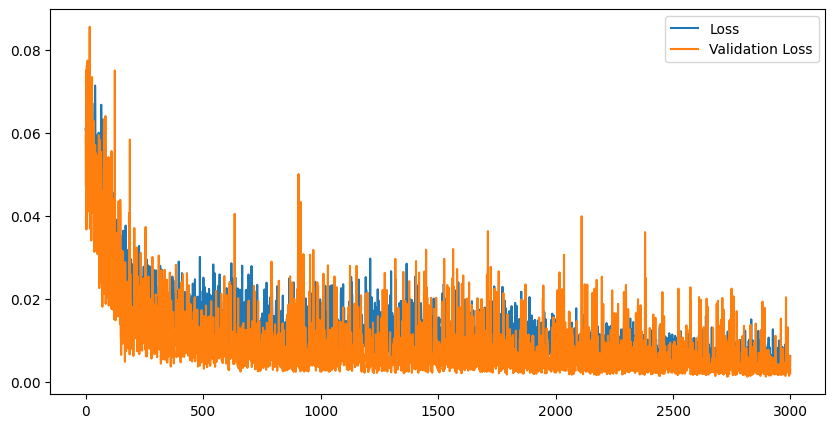

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()
plt.show()

In [11]:
torch.save(model.encoder, 'model.pt')